### Data Cleaning and Feature Creation

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.compose import TransformedTargetRegressor

#Load the data
price_data = pd.read_csv('pricedBitcoin2009-2018.csv')
occ_chainlets = pd.read_csv('OccChainletsInTime.txt', delimiter='\t')
amo_chainlets = pd.read_csv('AmoChainletsInTime.txt', delimiter='\t')

# Merge chainlet files with price data
amo_combined = pd.merge(
    amo_chainlets, price_data, on=['year', 'day'],
    how='inner', suffixes=('', '_price')
)
occ_combined = pd.merge(
    occ_chainlets, price_data, on=['year', 'day'],
    how='inner', suffixes=('', '_price')
)

# Merge the two chainlet DataFrames together
full_combined = pd.merge(
    amo_combined, occ_combined, on=['year', 'day'],
    how='inner', suffixes=('_amo', '_occ')
)

# Rename one of the price columns to 'price_target' for clarity
full_combined.rename(columns={'price_occ': 'price_target'}, inplace=True)

# Sort chronologically by year, day
full_combined.sort_values(['year', 'day'], inplace=True)

# Create lagged price features
max_lag = 3
for lag in range(1, max_lag):
    full_combined[f'price_lag_{lag}'] = full_combined['price_target'].shift(lag)

# Calculate momentum, 3-day moving average, and 5-day moving average with lagged price_target
full_combined['momentum'] = (
    full_combined['price_target'].shift(1) - 
    full_combined['price_target'].shift(2)
)

# 3-day moving average of price_target, shifted by 1 day
full_combined['ma_3'] = (
    full_combined['price_target'].shift(1)
    .rolling(window=3)
    .mean()
)

# 5-day moving average of price_target, shifted by 1 day
full_combined['ma_5'] = (
    full_combined['price_target'].shift(1)
    .rolling(window=5)
    .mean()
)

# Drop rows with NaN values
full_combined.dropna(inplace=True)

# Define input features and target
chainlet_features = [col for col in full_combined.columns if ':' in col]
lagged_cols = [f'price_lag_{lag}' for lag in range(1, max_lag)]
engineered_features = ['momentum', 'ma_3', 'ma_5']

input_features = chainlet_features + lagged_cols + engineered_features
X = full_combined[input_features]
y = full_combined['price_target']


### Training and Fitting of Model

TimeSeriesSplit CV RMSE scores: [ 10.28747751 647.34857427 271.4378328  102.38810032 374.75745955]
Mean CV RMSE: 281.2438888892609
Final Test RMSE (December 2017): 1039.18167560743
Predictions + daily RMSE saved to bitcoin_predictions_dec_2017.csv


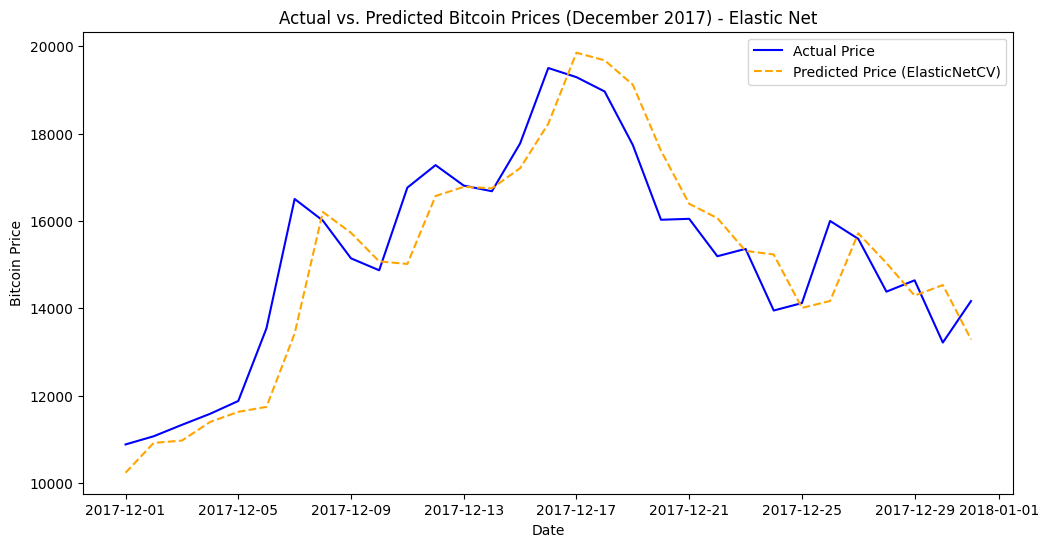

In [8]:
# Implement a pipeline with ElasticNetCV and TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Create an ElasticNetCV regressor that scales the target
regressor = TransformedTargetRegressor(
    regressor=ElasticNetCV(
        alphas=np.logspace(-4, 3, 20),
        l1_ratio=np.linspace(0.1, 1.0, 5),
        cv=tscv,
        max_iter=10000,
        tol=1e-4,
        random_state=42
    ),
    transformer=StandardScaler()  # scales the target
)
# Create a pipeline with the regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # scales the features X
    ('model', regressor)
])

cv_scores = cross_val_score(
    pipeline, X, y, 
    scoring='neg_mean_squared_error', 
    cv=tscv
)
rmse_scores = np.sqrt(-cv_scores)
print("TimeSeriesSplit CV RMSE scores:", rmse_scores)
print("Mean CV RMSE:", rmse_scores.mean())

# Split the data into training and test sets
final_train = full_combined[
    ~((full_combined['year'] == 2017) & (full_combined['day'] >= 335))
]
final_test = full_combined[
    (full_combined['year'] == 2017) & (full_combined['day'] >= 335)
]
# Train-test split
X_train = final_train[input_features]
y_train = final_train['price_target']
X_test = final_test[input_features]
y_test = final_test['price_target']

# Fit on training portion
pipeline.fit(X_train, y_train)

# Predict on final test
predictions = pipeline.predict(X_test)

# Overall RMSE for December 2017
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Final Test RMSE (December 2017):", test_rmse)

# Save predictions and daily RMSE to a CSV file
test_data_viz = final_test.copy()

# Convert year/day to a proper date (year + day-of-year)
test_data_viz['date'] = pd.to_datetime(
    test_data_viz['year'].astype(str) + test_data_viz['day'].astype(str),
    format='%Y%j'
)

# Add columns for actual & predicted price
test_data_viz['actual_price'] = y_test.values
test_data_viz['predicted_price'] = predictions

# Compute daily RMSE 
test_data_viz['daily_rmse'] = np.abs(test_data_viz['actual_price'] - test_data_viz['predicted_price'])

# Save to CSV
csv_filename = "bitcoin_predictions_dec_2017.csv"
test_data_viz[['date', 'actual_price', 'predicted_price', 'daily_rmse']].to_csv(csv_filename, index=False)

print(f"Predictions + daily RMSE saved to {csv_filename}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data_viz['date'], test_data_viz['actual_price'], label='Actual Price', color='blue')
plt.plot(test_data_viz['date'], test_data_viz['predicted_price'],
         label='Predicted Price (ElasticNetCV)', 
         color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Actual vs. Predicted Bitcoin Prices (December 2017) - Elastic Net')
plt.legend()
plt.show()